<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Semantic Segmentation using IceVision

## Install

In [3]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

## Imports

In [1]:
from icevision.all import *

/opt/homebrew/Caskroom/miniforge/base/envs/icevision-dev/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")
INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /Users/nicjac/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /Users/nicjac/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


## Getting and parsing the data

In [3]:
data_url = 'https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz'
data_dir = icedata.load_data(data_url, 'camvid_tiny') / 'camvid_tiny'

In [4]:
codes = np.loadtxt(data_dir/'codes.txt', dtype=str)
class_map = ClassMap(list(codes))

In [5]:
images_dir = data_dir/'images'
labels_dir = data_dir/'labels'

In [6]:
image_files = get_image_files(images_dir)

In [7]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}_P.png')
    record.segmentation.set_mask(mask_file)
    
records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

100%|██████████| 100/100 [00:00<00:00, 31857.09it/s]


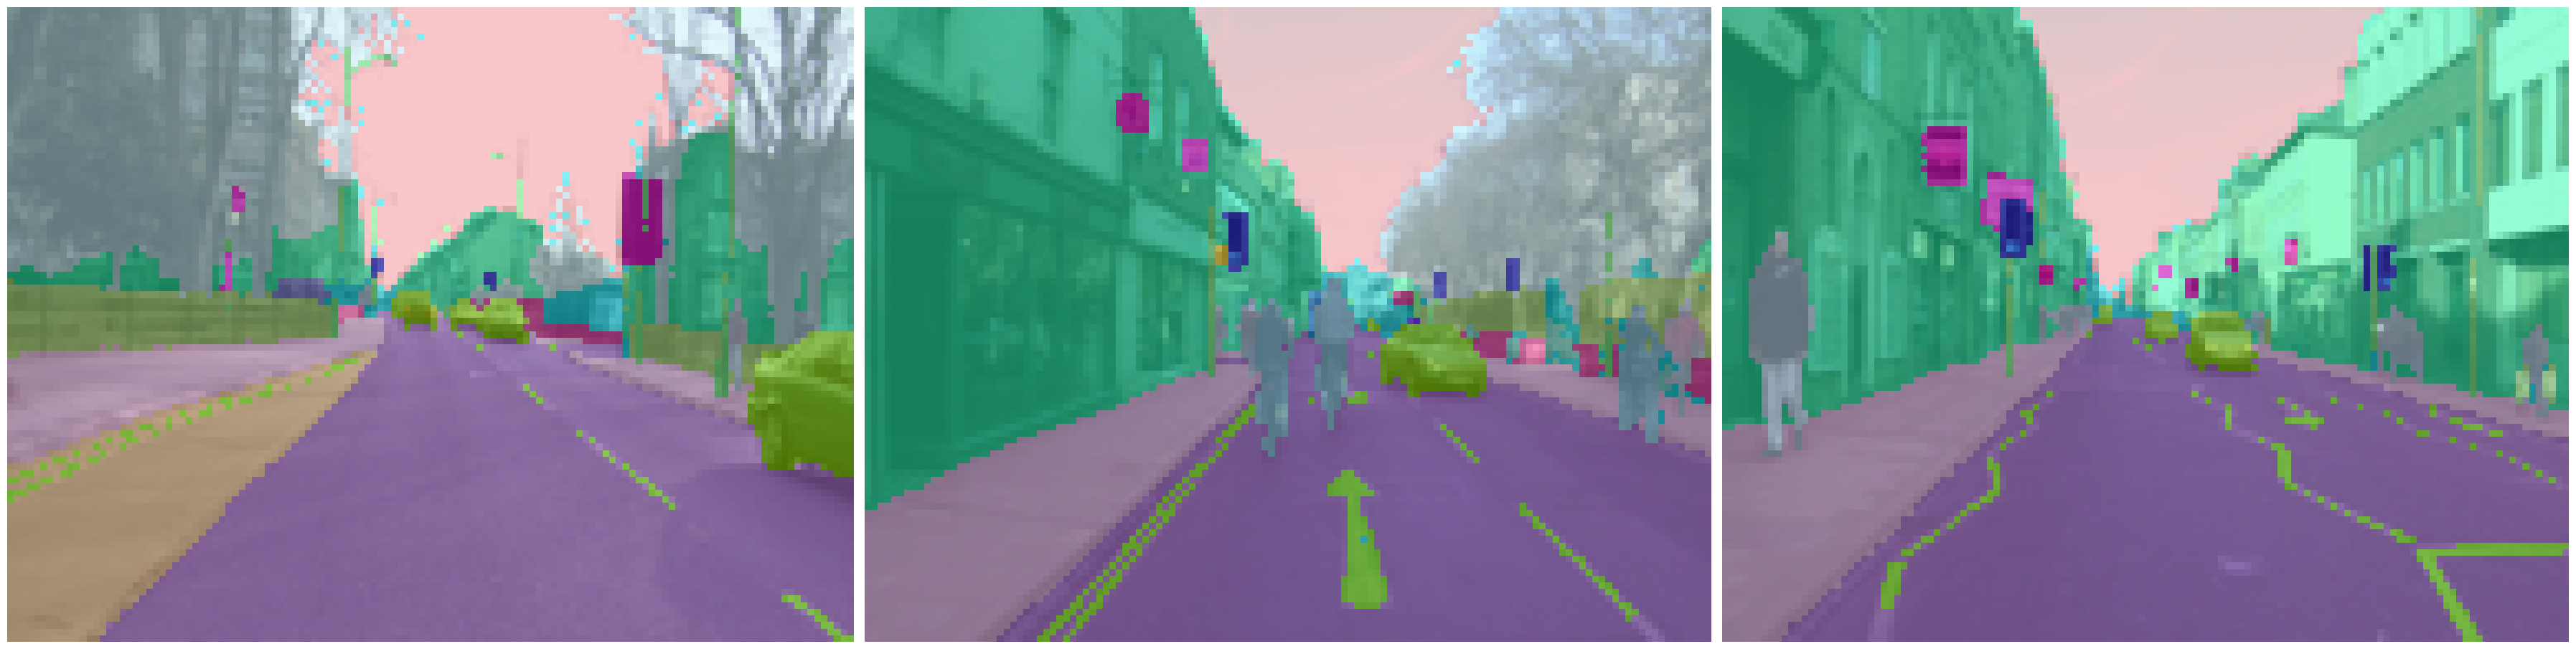

In [8]:
sample_records = random.choices(records, k=3)
show_records(sample_records, ncols=3)

## Transforms and datasets

In [9]:
presize, size = 512, 384
presize, size = ImgSize(presize, int(presize*.75)), ImgSize(size, int(size*.75))

aug_tfms = tfms.A.aug_tfms(presize=presize, size=size, pad=None,
                           crop_fn=partial(tfms.A.RandomCrop, p=0.5),
                           shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=2),
                          )
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [10]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

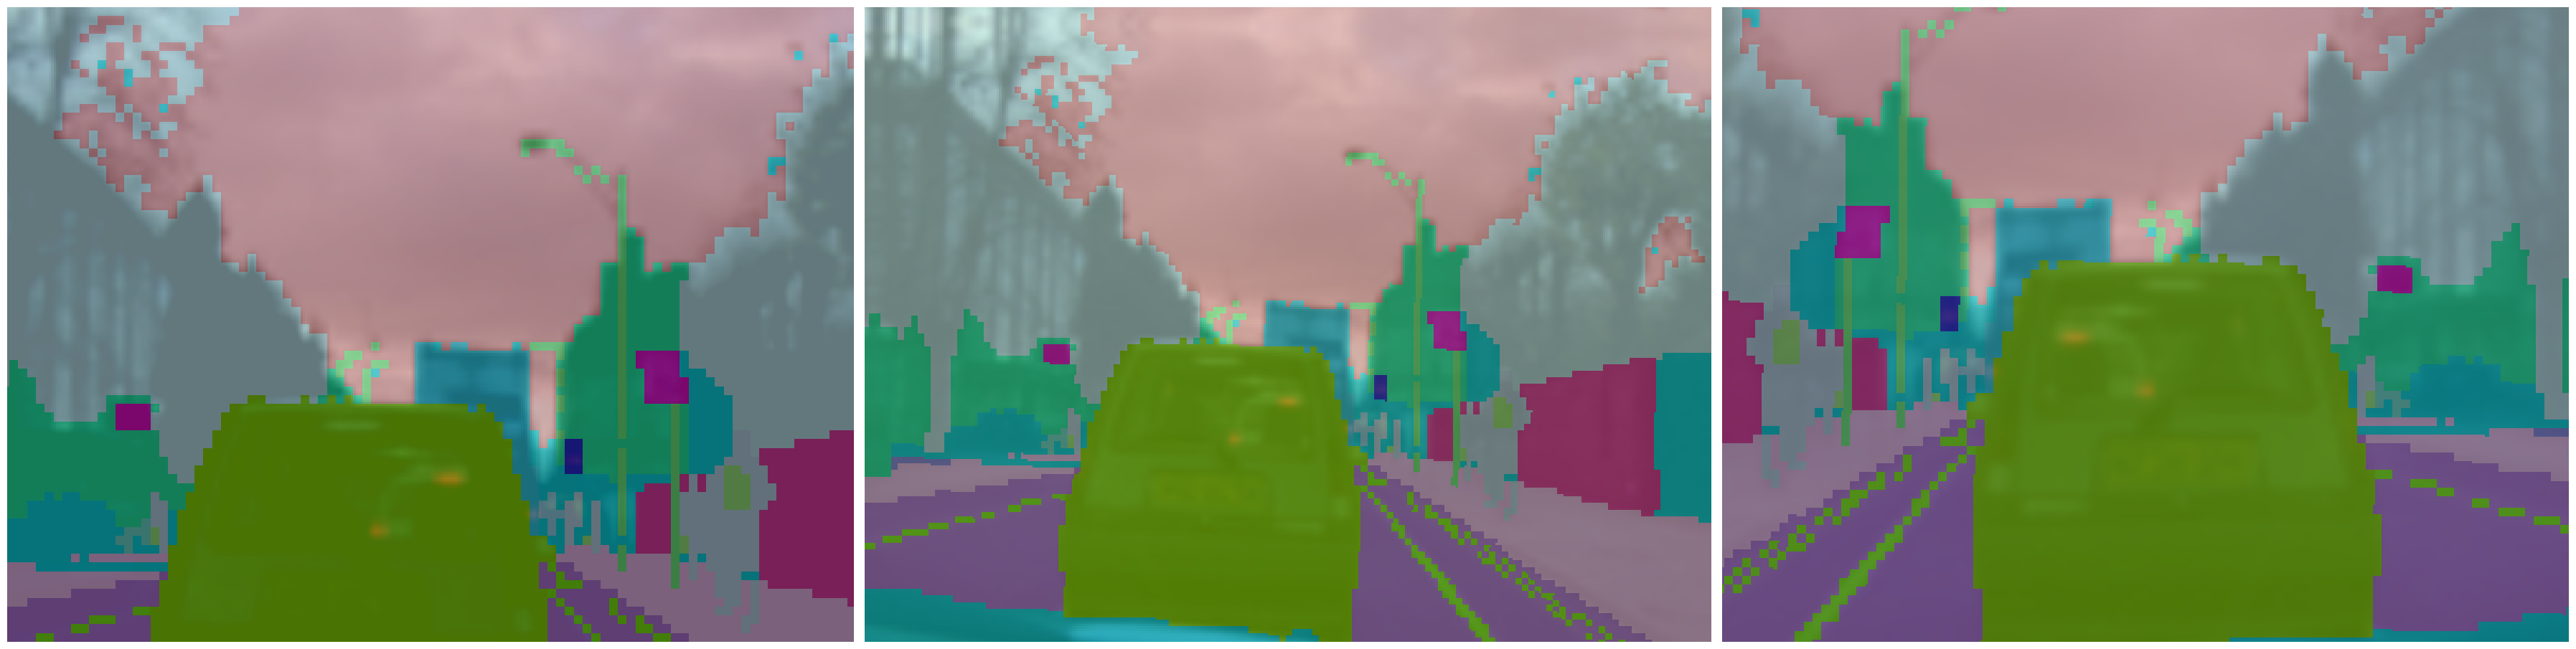

In [11]:
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

# Select a library, model, and backbone

In order to create a model, we need to:

- Choose one of the **libraries** supported by IceVision
- Choose one of the **models** supported by the library
- Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.

### Creating a model

Selections only take two simple lines of code. For example, to try the `mmsegmentation` library using the `deeplabv3` model and the `resnet50_d8` backbone could be specified by:

```python
model_type = models.mmseg.deeplab3
backbone = model_type.backbones.backbones.resnet50_d8
```

As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.

In [14]:
selection = 0


if selection == 0:
  model_type = models.fastai.unet
  backbone = model_type.backbones.resnet34()

if selection == 1:
  model_type = models.mmseg.deeplabv3
  backbone = model_type.backbones.backbones.resnet50_d8

if selection == 2:
  model_type = models.mmseg.deeplabv3
  backbone = model_type.backbones.backbones.resnet50_d8


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/nicjac/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:30<00:00, 2.82MB/s]


## Data Loader
The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [15]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [16]:
backbone = model_type.backbones.resnet34()
model = model_type.model(backbone=backbone, num_classes=class_map.num_classes, img_size=size)

## Defining and training the `fastai` learner

In [17]:
def accuracy_camvid(pred, target):
    # ignores void pixels
    keep_idxs = target != class_map.get_by_name('Void')
    target = target[keep_idxs]
    pred = pred.argmax(dim=1)[keep_idxs]

    return (pred==target).float().mean() 

In [18]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=[accuracy_camvid])

In [ ]:
learn.fine_tune(10, 1e-4)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,3.392160,2.630378,0.255401,00:09


epoch,train_loss,valid_loss,accuracy_camvid,time
0,2.602331,2.325062,0.440709,00:07
1,2.381318,1.799831,0.530444,00:07
2,2.142349,1.332237,0.668531,00:07
3,1.917440,1.123698,0.693745,00:07
4,1.747154,0.993772,0.751023,00:07
5,1.598631,0.996451,0.762109,00:07
6,1.491493,0.948187,0.774137,00:07
7,1.395746,0.869413,0.793335,00:07
8,1.311806,0.876654,0.794053,00:07
9,1.256938,0.868124,0.796351,00:07


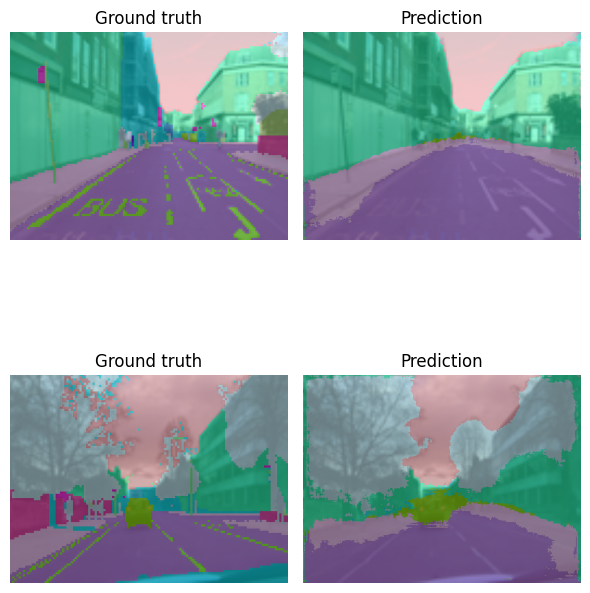

In [ ]:
model_type.show_results(model, valid_ds, num_samples=2)

## Inference

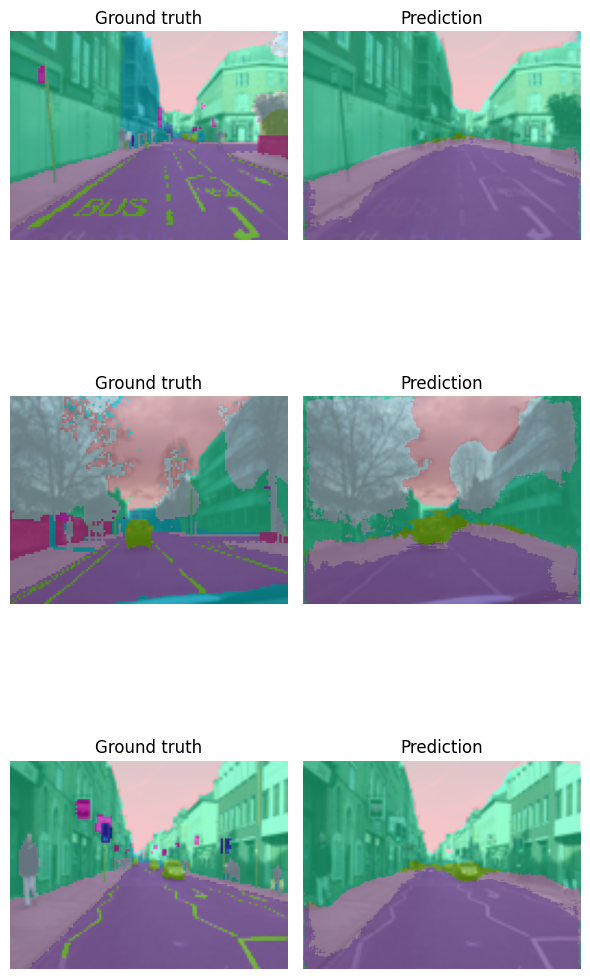

In [ ]:
preds = model_type.predict(model, valid_ds)
show_preds(preds=preds[:3])

In [ ]:
infer_dl = model_type.infer_dl([valid_ds[0]], batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/1 [00:00<?, ?it/s]

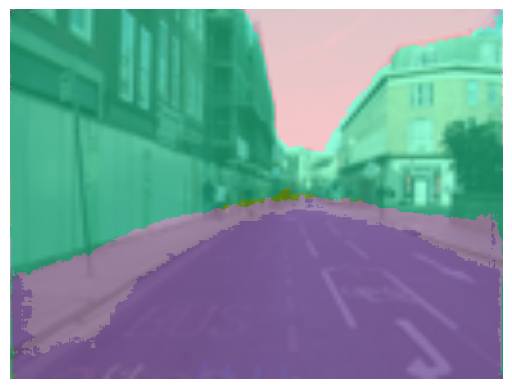

In [ ]:
show_sample(preds[0].pred)